### Header

In [1]:
# import libraries

# maths
import numpy as np
import pandas as pd

# visual
#from matplotlib_venn import venn2
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 14
sns.set_style('whitegrid')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon

# others
import os
import re
import time
import datetime as datetime

In [2]:
# file paths

input_path = '../data/2_input/'
clean_path = '../data/3_clean/'
output_path = '../data/4_output/'

image_path = '../images/'

### Functions

### Import Data

In [3]:
# import clean data

df_train = pd.read_csv(clean_path + 'train_clean.csv')
df_test = pd.read_csv(clean_path + 'test_clean.csv')
street_map = gpd.read_file('../data/2_input/Chicago Boundaries/geo_export_d41dc94d-31ce-478c-902c-864695385885.shp')
df_weather = pd.read_csv(clean_path + 'weather_clean.csv')
df_spray = pd.read_csv(clean_path + 'spray_clean.csv')

### EDA

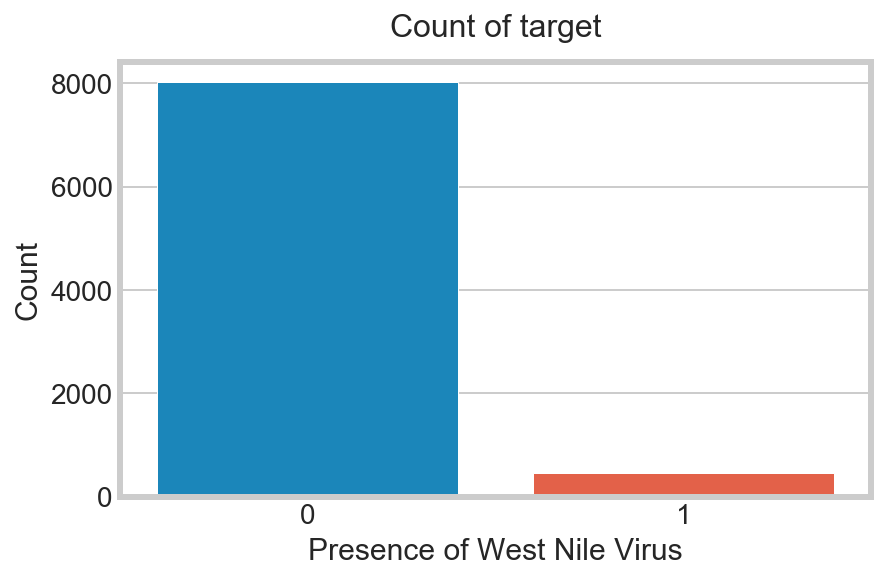

In [4]:
# The target is imbalanced, which will be taken care of before modelling is done.
sns.barplot(x=[0,1], y=df_train.wnvpresent.value_counts())
plt.xlabel('Presence of West Nile Virus', fontsize=15)
plt.ylabel('Count',fontsize=15)
plt.tick_params(labelsize=14)
plt.title('Count of target',fontsize=16, y=1.03)
plt.show()

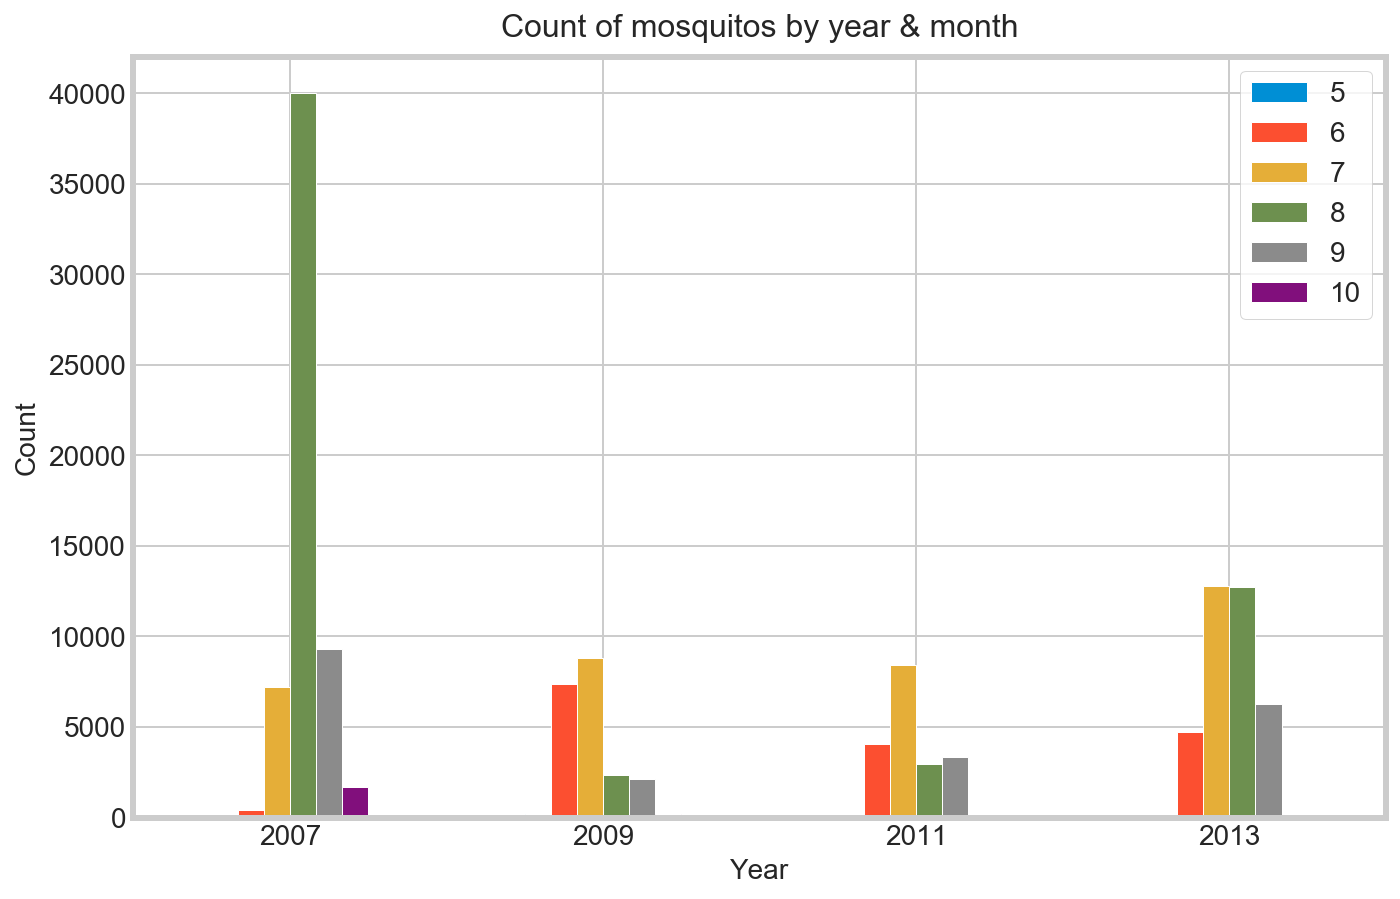

In [5]:
# Highest number of mosquitos caught in Jul, Aug
df_train.groupby(['year','month']).nummosquitos.sum().unstack(fill_value=0).plot.bar(figsize=(10,7))
plt.xticks(rotation=0, fontsize=14)
plt.yticks(fontsize=14)
plt.title('Count of mosquitos by year & month', fontsize=16, y=1.01)
plt.ylabel('Count', fontsize=14)
plt.xlabel('Year',fontsize=14)
plt.legend(fontsize=14)
plt.show()

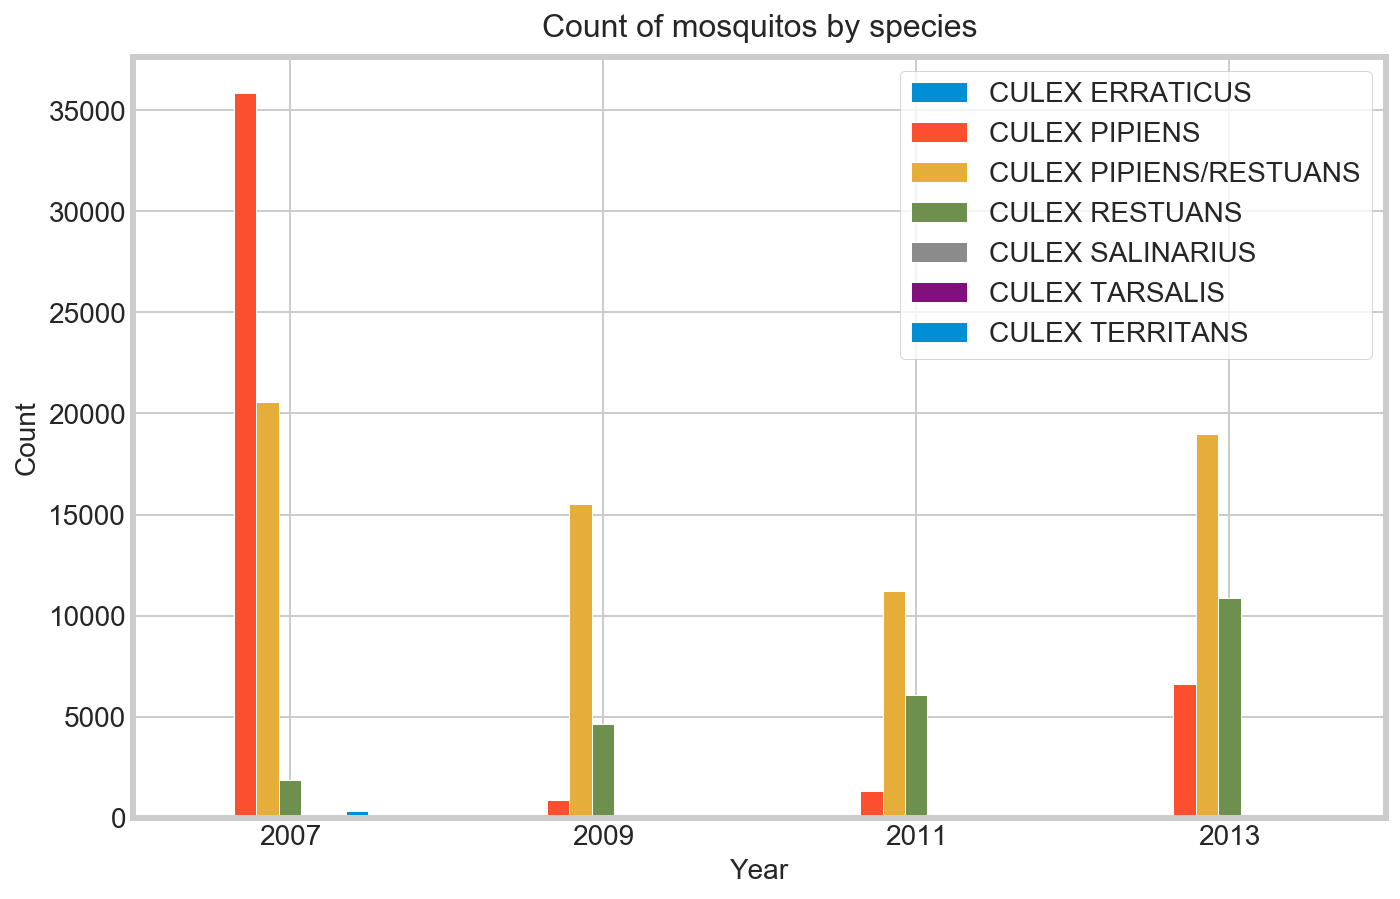

In [6]:
# Most common species of mosquitos caught are Culex Pipiens and Culex Restuans
# Proportion of each species are the same except for 2007
df_train.groupby(['year','species']).nummosquitos.sum().unstack(fill_value=0).plot.bar(figsize=(10,7))
plt.xticks(rotation=0, fontsize=14)
plt.yticks(fontsize=14)
plt.title('Count of mosquitos by species', fontsize=16, y=1.01)
plt.ylabel('Count', fontsize=14)
plt.xlabel('Year',fontsize=14)
plt.legend(fontsize=14)
plt.show()

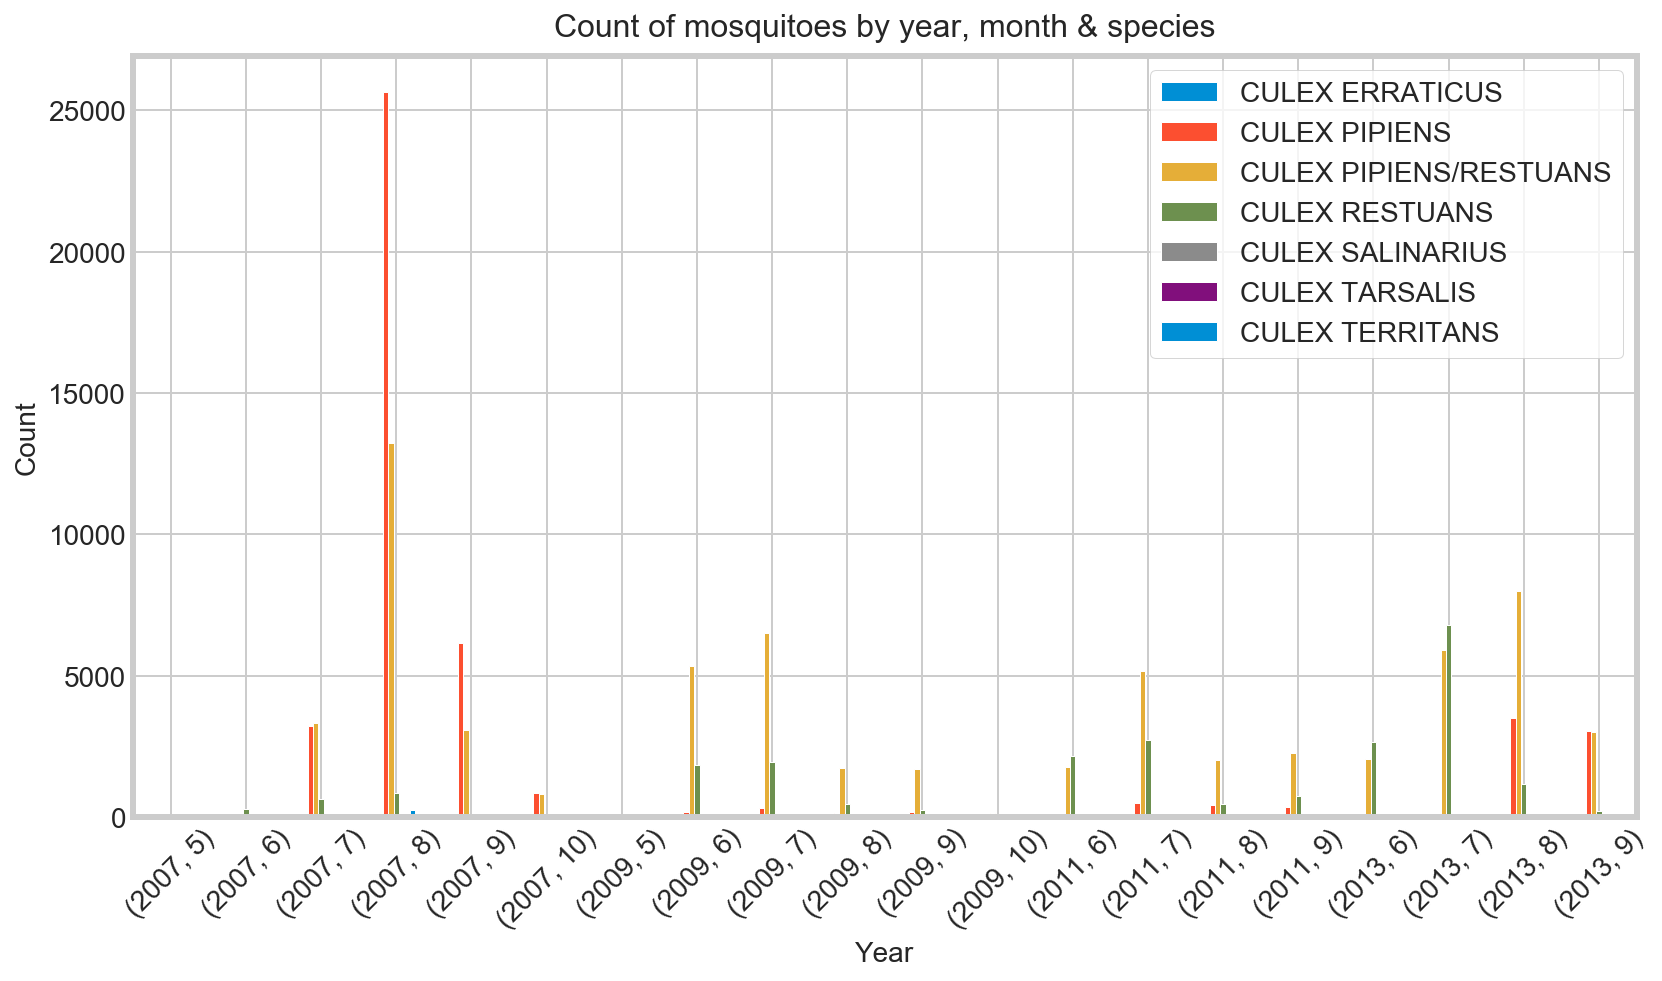

In [7]:
# not much insights to draw from this plot - to remove? 
df_train.groupby(['year','month', 'species']).nummosquitos.sum().unstack(fill_value=0).plot.bar(figsize=(12,7))
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
plt.title('Count of mosquitoes by year, month & species', fontsize=16, y=1.01)
plt.ylabel('Count', fontsize=14)
plt.xlabel('Year',fontsize=14)
plt.legend(fontsize=14)
plt.show()

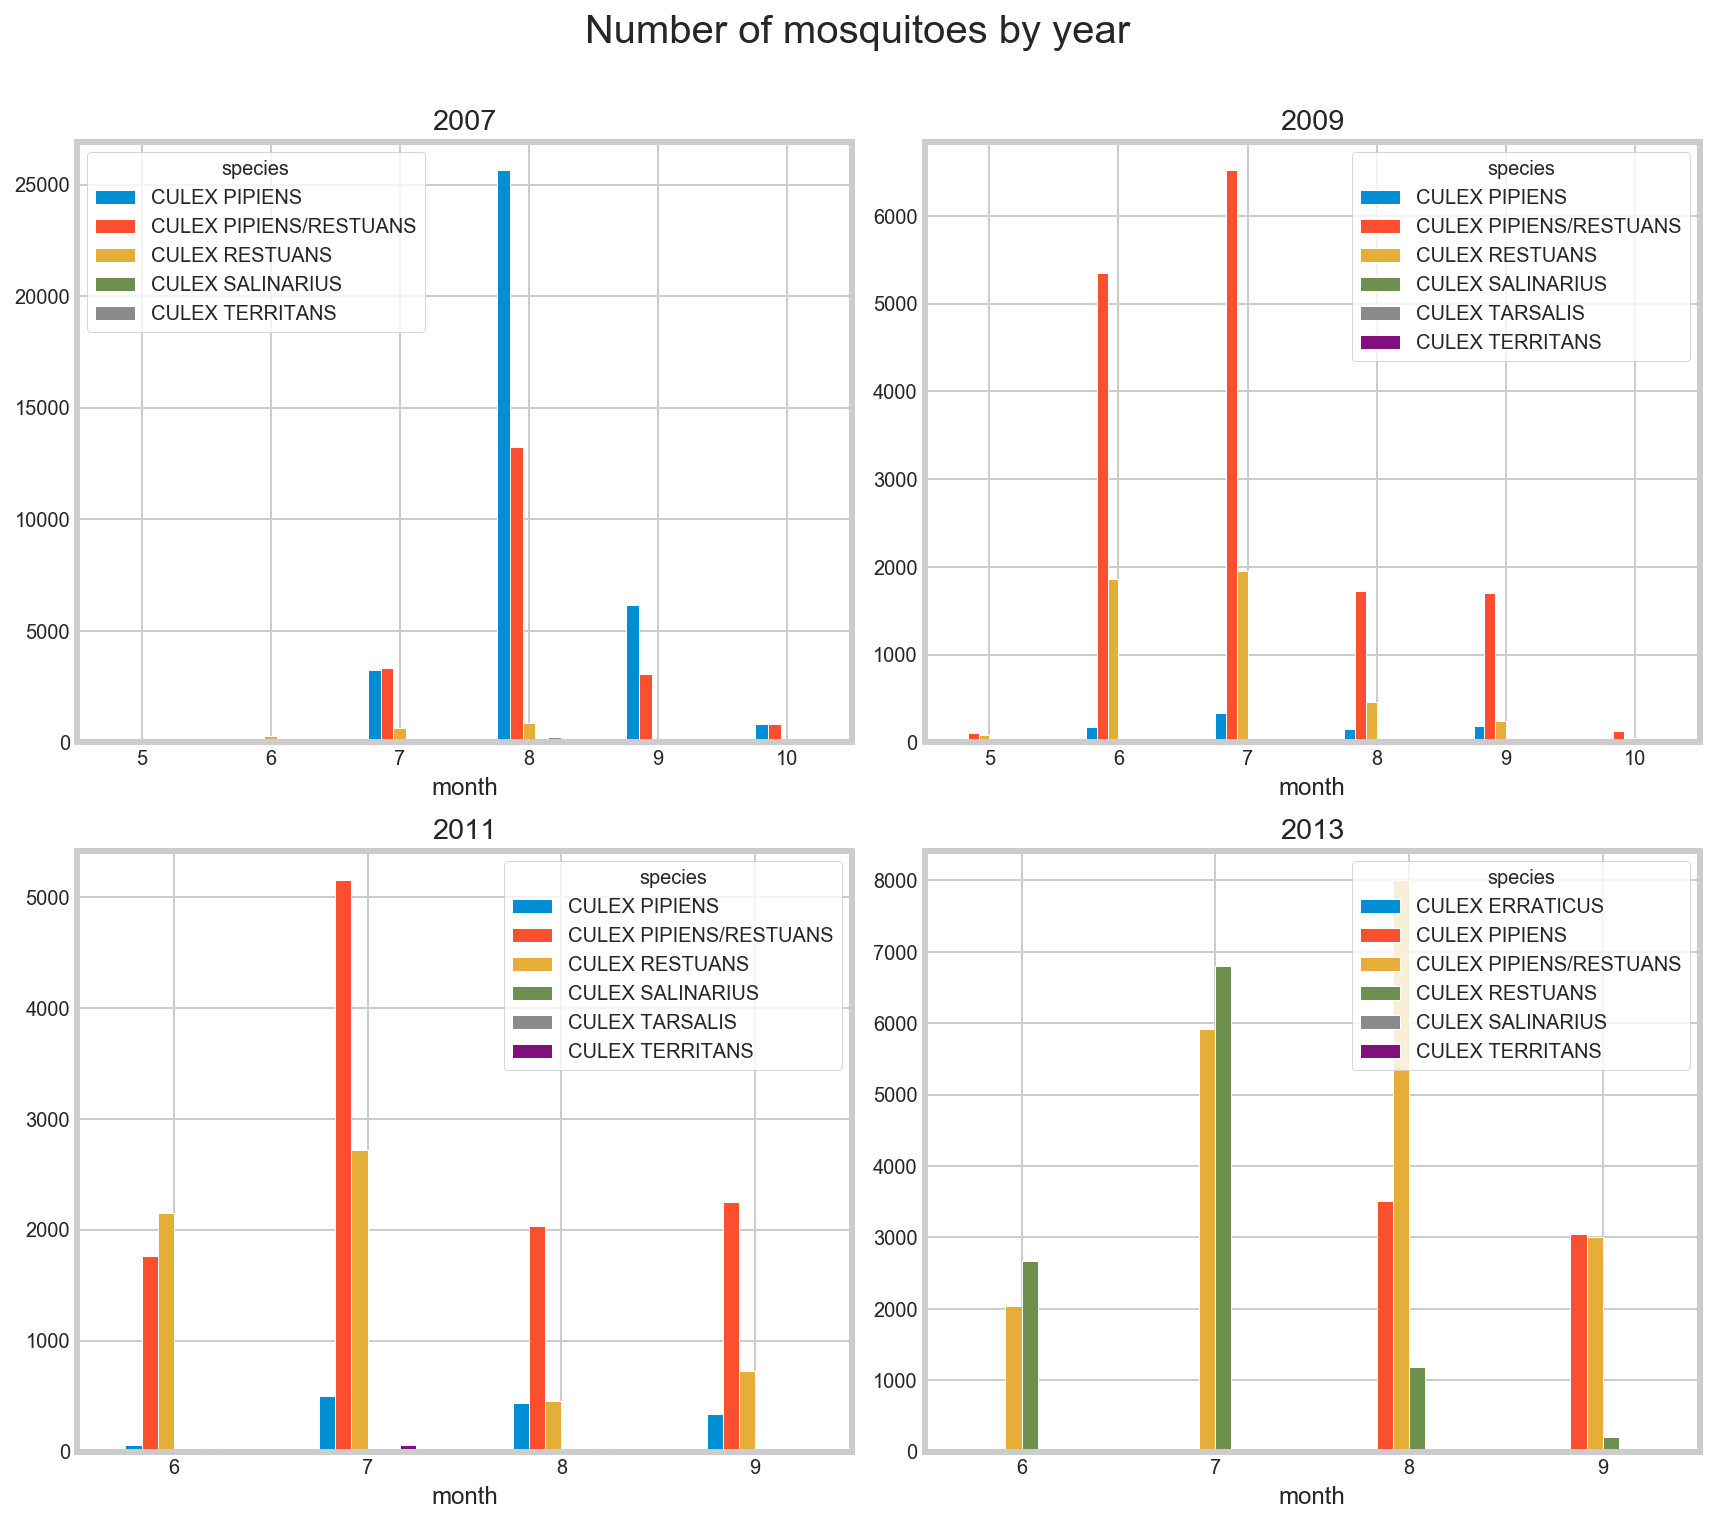

In [8]:
# same as above but can see the breakdown more clearly
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,10))
ax = ax.ravel()
plt.suptitle('Number of mosquitoes by year', fontsize=20, y=1.05)
for i, y in enumerate(df_train.year.unique()):
    df_train[df_train['year']==y].groupby(['month', 'species']).nummosquitos.sum().unstack(fill_value=0).plot.bar(ax=ax[i])
    ax[i].set_title(y)
    ax[i].tick_params(axis='x', labelrotation=0)
plt.tight_layout()

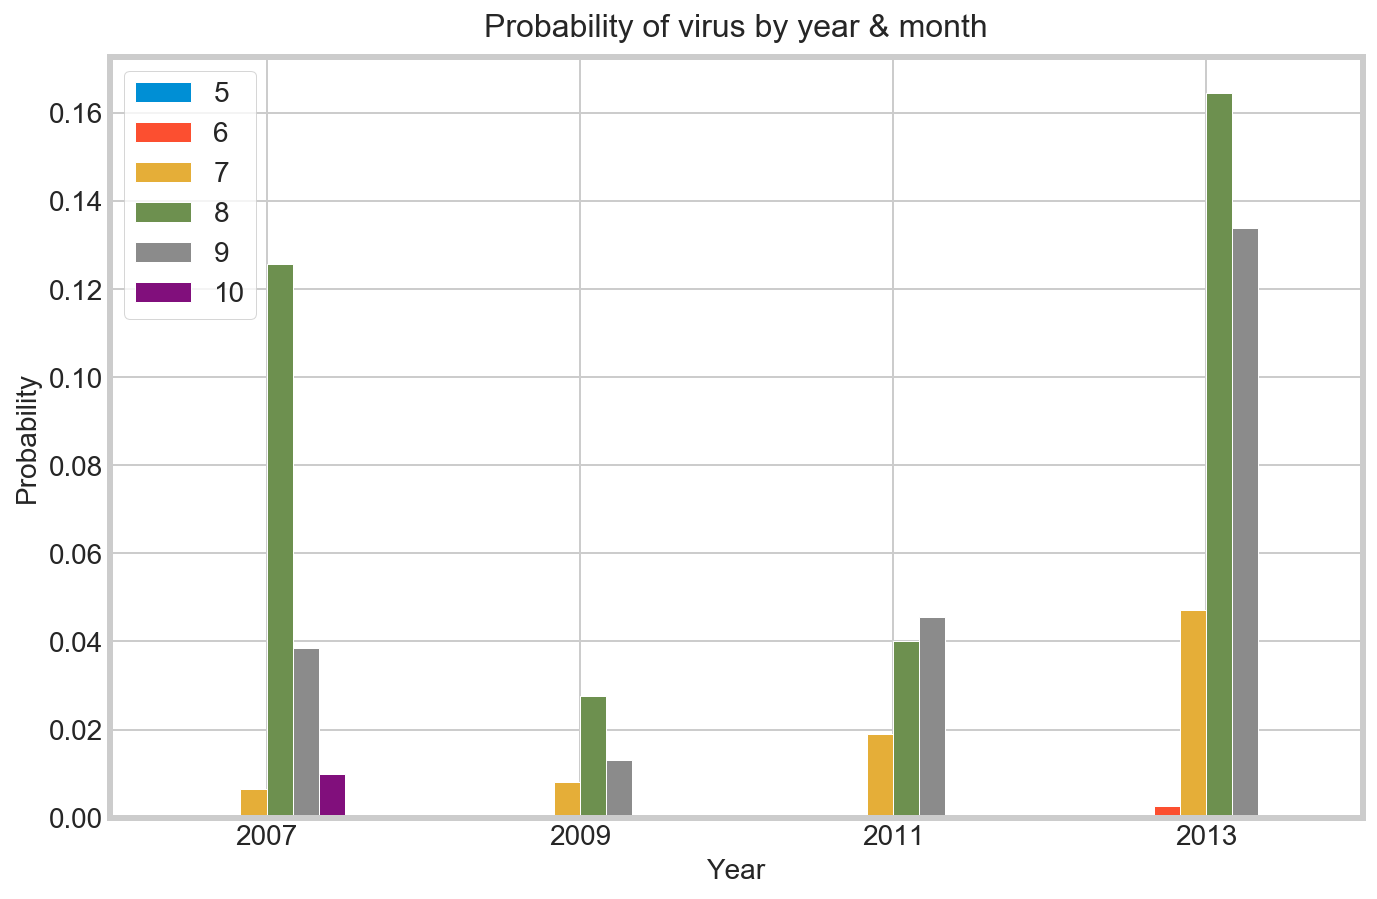

In [9]:
# Highest number of mosquitos caught in Jul, Aug
df_train.groupby(['year','month']).wnvpresent.mean().unstack(fill_value=0).plot.bar(figsize=(10,7))
plt.xticks(rotation=0, fontsize=14)
plt.yticks(fontsize=14)
plt.title('Probability of virus by year & month', fontsize=16, y=1.01)
plt.ylabel('Probability', fontsize=14)
plt.xlabel('Year',fontsize=14)
plt.legend(fontsize=14)
plt.show()

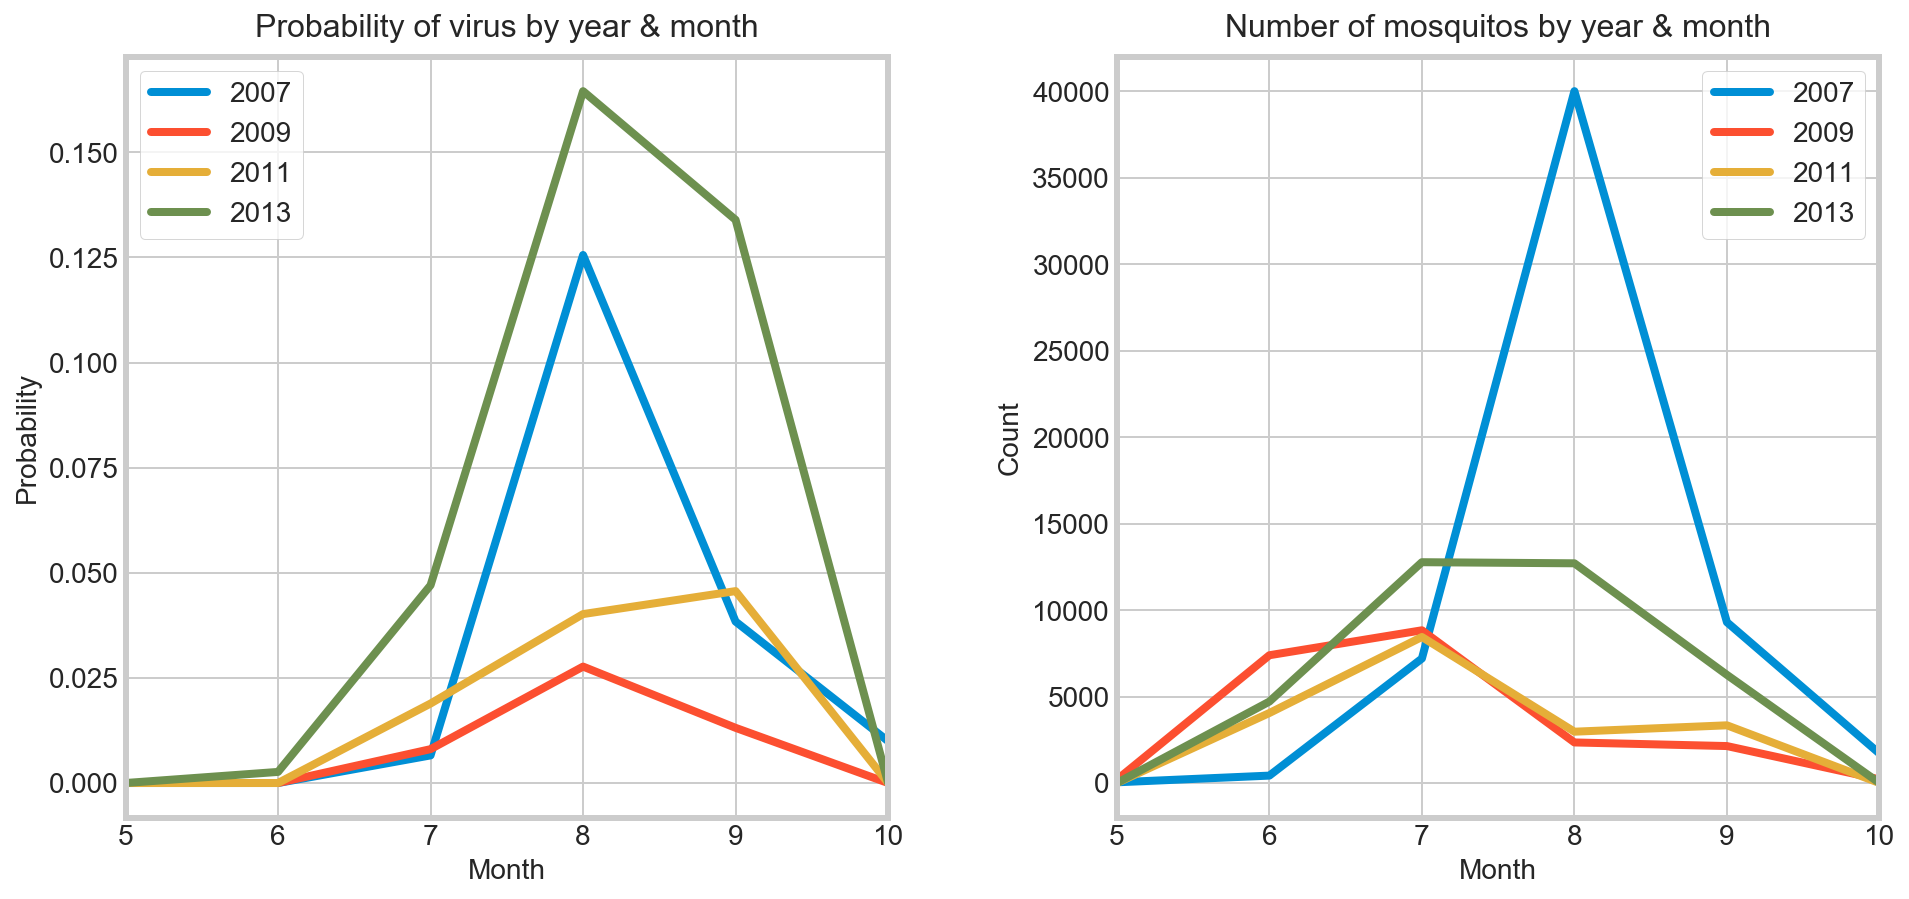

In [10]:
# Highest probability of virus in Aug except for 2011, where highest probability of virus was in Sep
# Higher number of mosquito does not indicate higher probability of virus 
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,7))
ax = ax.ravel()
df_train.groupby(['month', 'year']).wnvpresent.mean().unstack(fill_value=0).plot(ax=ax[0])
df_train.groupby(['month', 'year']).nummosquitos.sum().unstack(fill_value=0).plot(ax=ax[1])

ax[0].set_title('Probability of virus by year & month', fontsize=16, y=1.01)
ax[0].set_ylabel('Probability', fontsize=14)
ax[0].set_xlabel('Month',fontsize=14)
ax[0].legend(fontsize=14)
ax[0].tick_params(labelsize=14)

ax[1].set_title('Number of mosquitos by year & month', fontsize=16, y=1.01)
ax[1].set_ylabel('Count', fontsize=14)
ax[1].set_xlabel('Month',fontsize=14)
ax[1].legend(fontsize=14)
ax[1].tick_params(labelsize=14)

plt.subplots_adjust(wspace=0.3)

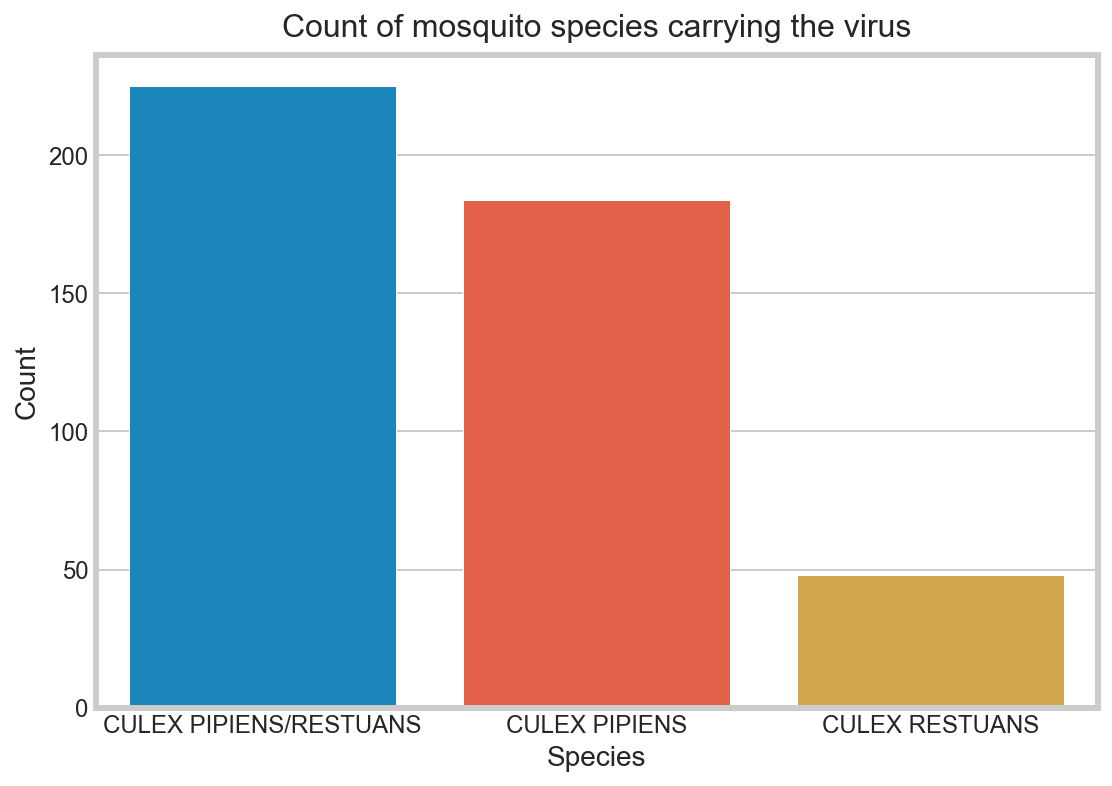

In [11]:
plt.figure(figsize=(8,6))
sns.countplot(df_train[df_train['wnvpresent']==1].species)
plt.title('Count of mosquito species carrying the virus', fontsize=16, y=1.01)
plt.tick_params(labelsize=12)
plt.xlabel('Species', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.show()

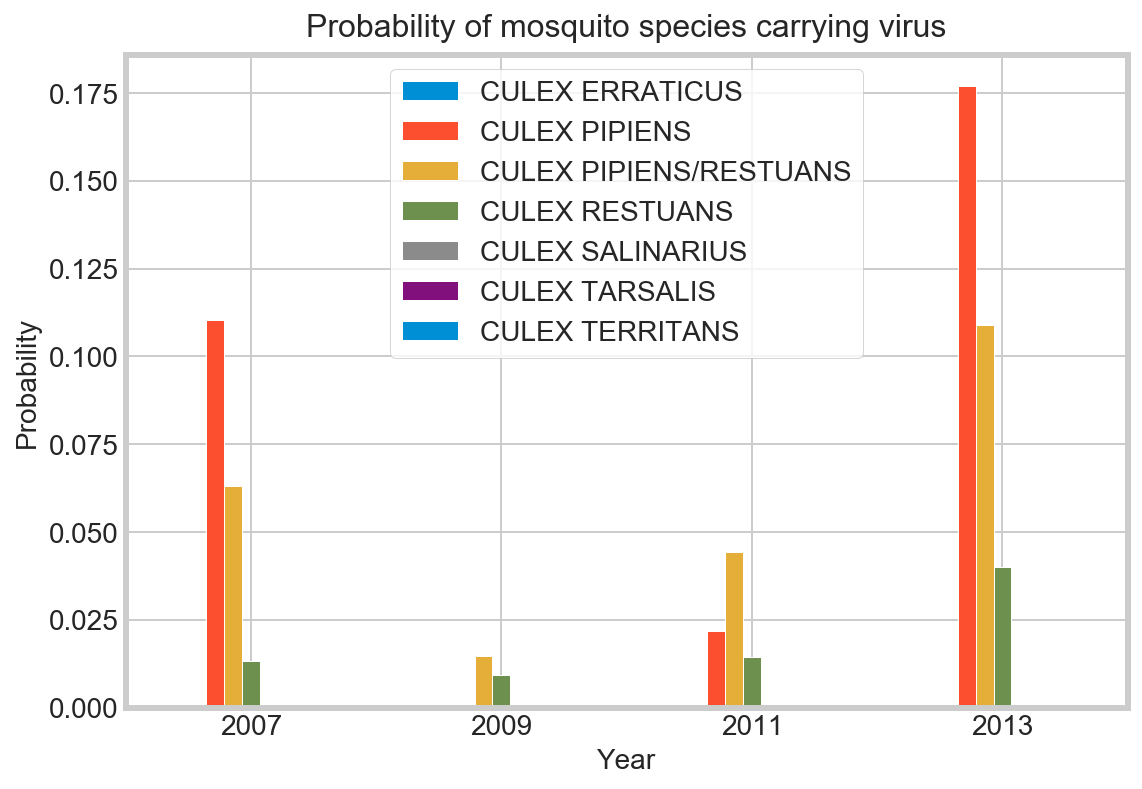

In [12]:
# Most common species of mosquitos caught are Culex Pipiens and Culex Restuans
# Proportion of each species are the same except for 2007
df_train.groupby(['year','species']).wnvpresent.mean().unstack(fill_value=0).plot.bar(figsize=(8,6))
plt.xticks(rotation=0, fontsize=14)
plt.yticks(fontsize=14)
plt.title('Probability of mosquito species carrying virus', fontsize=16, y=1.01)
plt.ylabel('Probability', fontsize=14)
plt.xlabel('Year',fontsize=14)
plt.legend(fontsize=14)
plt.show()

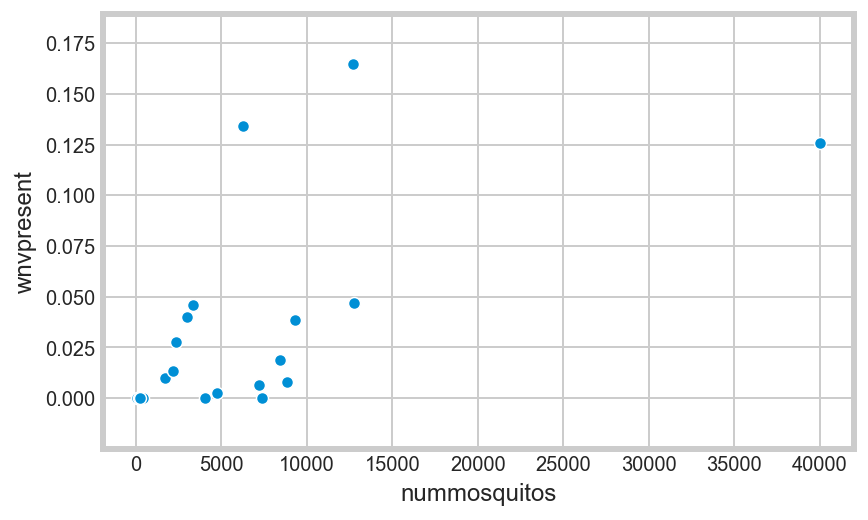

In [13]:
# looks like there is an outlier - to remove the graph?
sns.scatterplot(x=df_train.groupby(['year', 'month']).nummosquitos.sum(),
                y= df_train.groupby(['year', 'month']).wnvpresent.mean())

### Weather Data

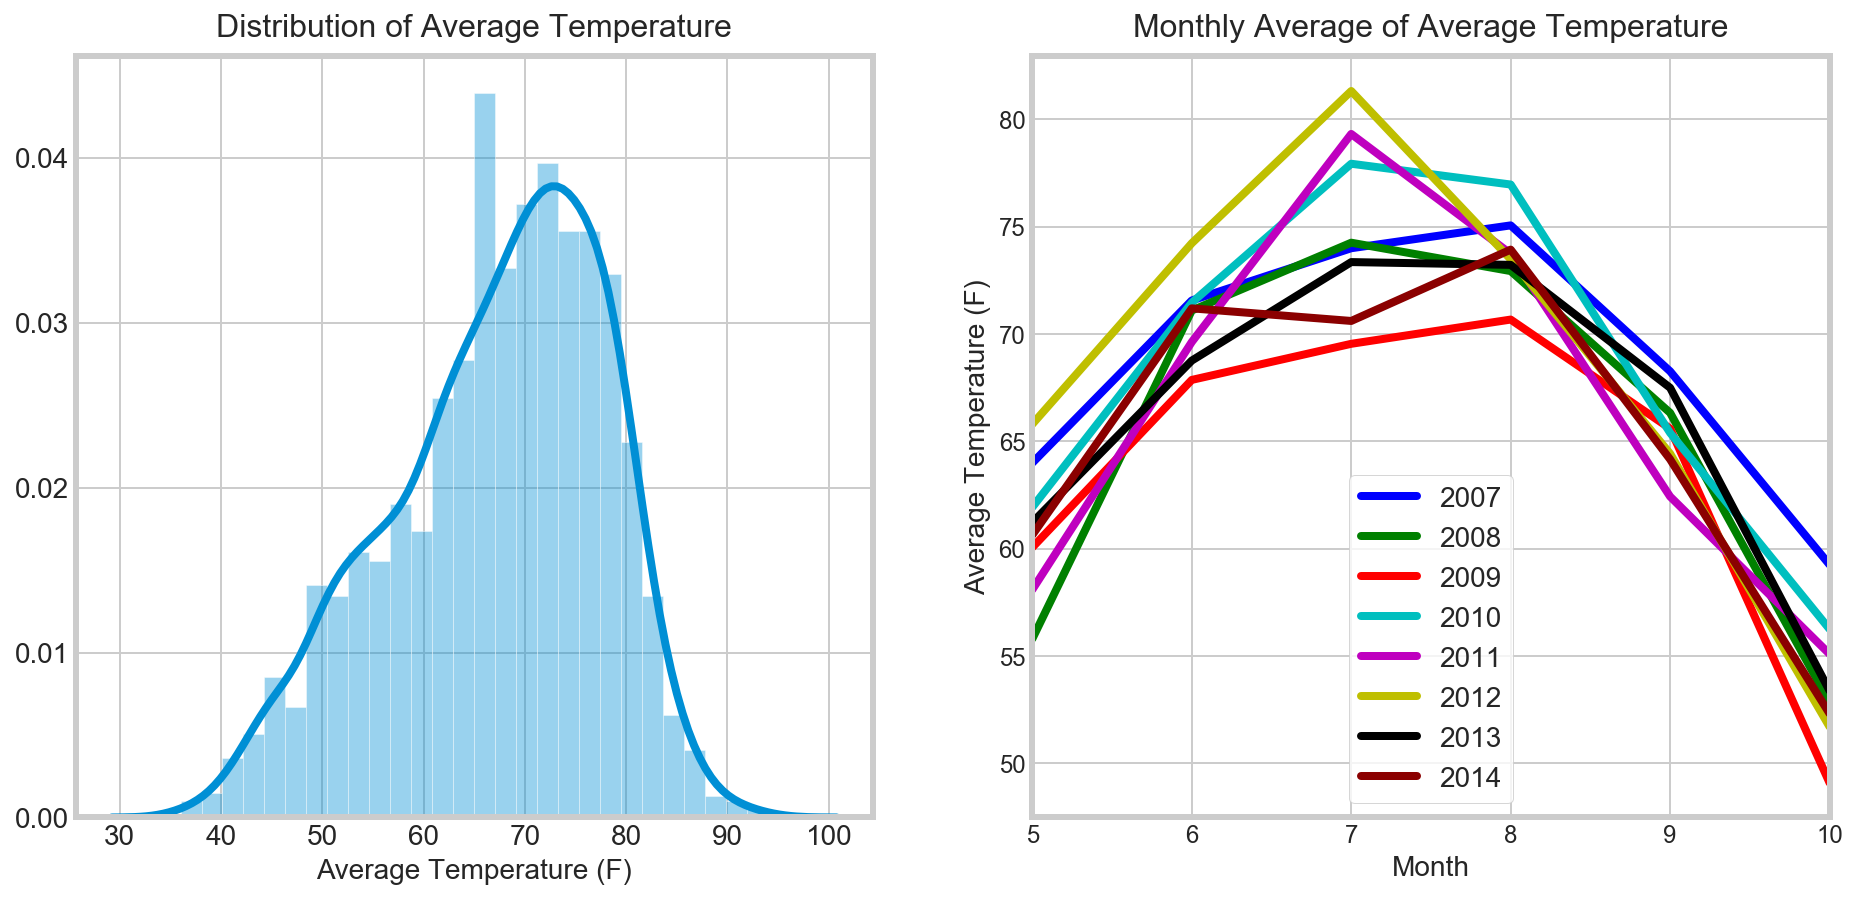

In [14]:
# Distribution of average temperature does not follow a normal distribution
# Average temperature peaks in Jul or Aug each year
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,7))
ax = ax.ravel()

sns.distplot(df_weather.tavg, ax=ax[0])
df_weather[df_weather['station']==1].groupby(['month','year']).tavg.mean().unstack(fill_value=0).plot(
    ax=ax[1], color=['b', 'g', 'r', 'c', 'm', 'y', 'k', 'darkred'])

ax[0].set_title('Distribution of Average Temperature', fontsize=16, y=1.01)
ax[0].set_xlabel('Average Temperature (F)', fontsize=14)
ax[0].tick_params(labelsize=14)

ax[1].set_title('Monthly Average of Average Temperature', fontsize=16, y=1.01)
ax[1].set_xlabel('Month', fontsize=14)
ax[1].set_ylabel('Average Temperature (F)', fontsize=14)
ax[1].tick_params(labelsize=12)
ax[1].legend(fontsize=14)

plt.subplots_adjust(wspace=0.2)

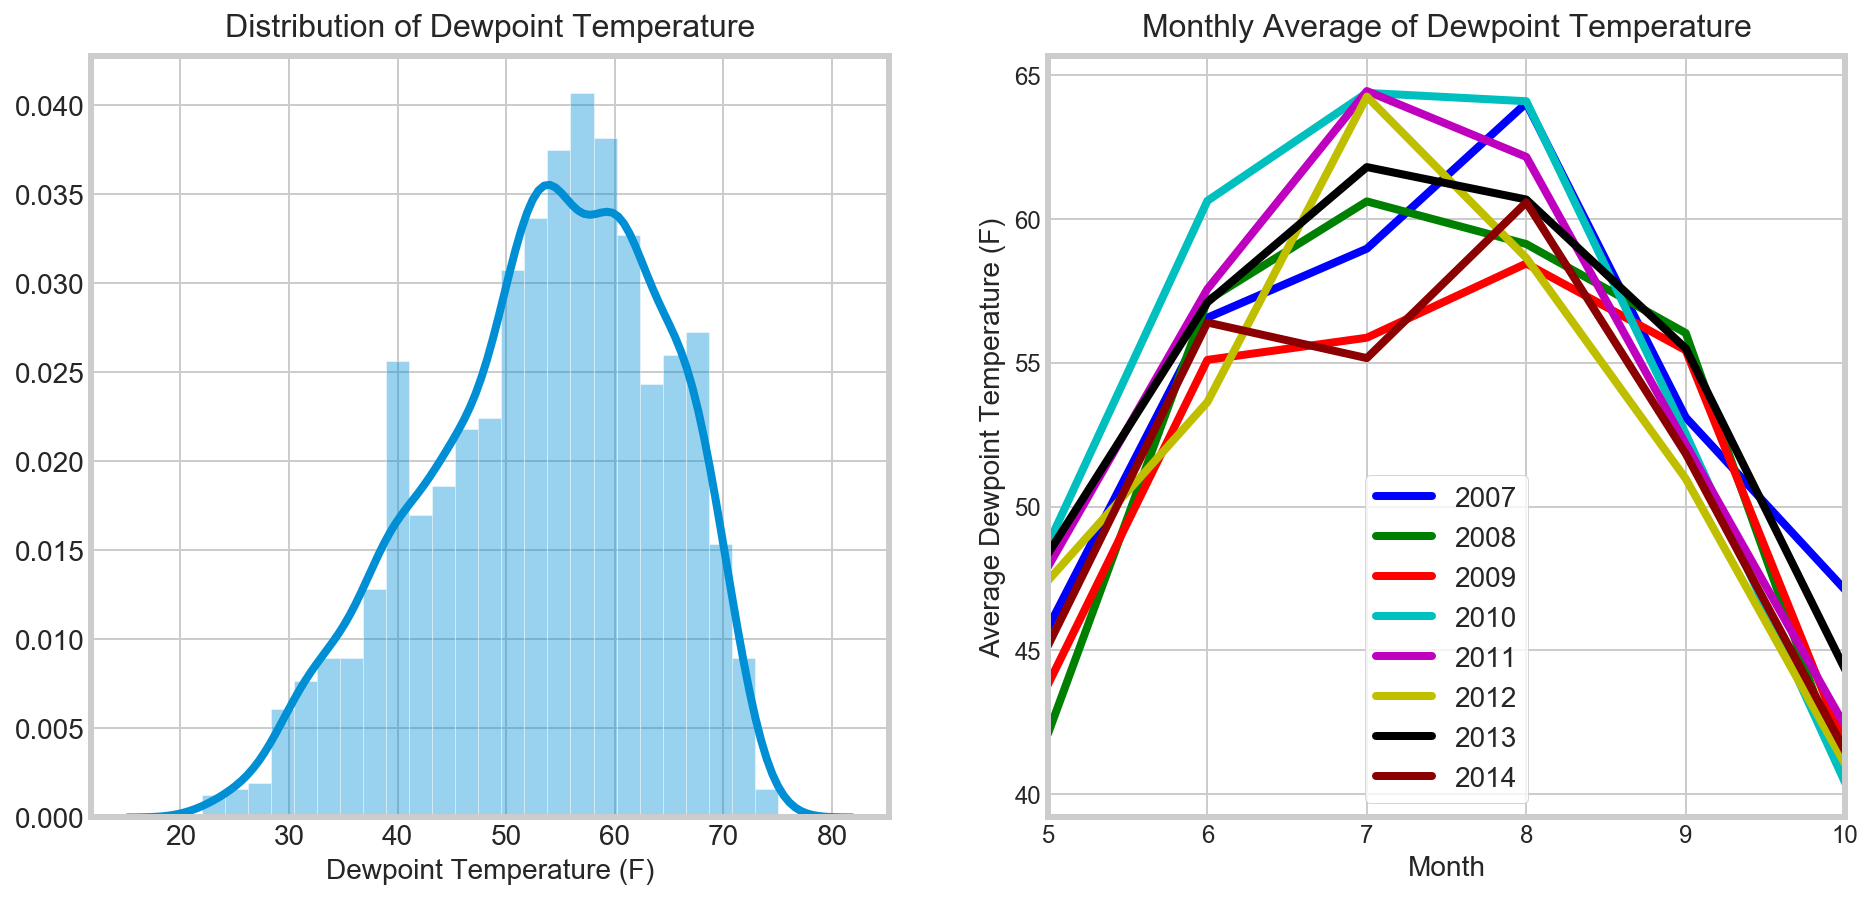

In [15]:
# Distribution of dewpoint temperature does not follow a normal distribution
# Dewpoint temperature peaks in Jul or Aug each year
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,7))
ax = ax.ravel()

sns.distplot(df_weather.dewpoint, ax=ax[0])
df_weather[df_weather['station']==1].groupby(['month','year']).dewpoint.mean().unstack(fill_value=0).plot(
    ax=ax[1], color=['b', 'g', 'r', 'c', 'm', 'y', 'k', 'darkred'])

ax[0].set_title('Distribution of Dewpoint Temperature', fontsize=16, y=1.01)
ax[0].set_xlabel('Dewpoint Temperature (F)', fontsize=14)
ax[0].tick_params(labelsize=14)

ax[1].set_title('Monthly Average of Dewpoint Temperature', fontsize=16, y=1.01)
ax[1].set_xlabel('Month', fontsize=14)
ax[1].set_ylabel('Average Dewpoint Temperature (F)', fontsize=14)
ax[1].tick_params(labelsize=12)
ax[1].legend(fontsize=14)

plt.subplots_adjust(wspace=0.2)

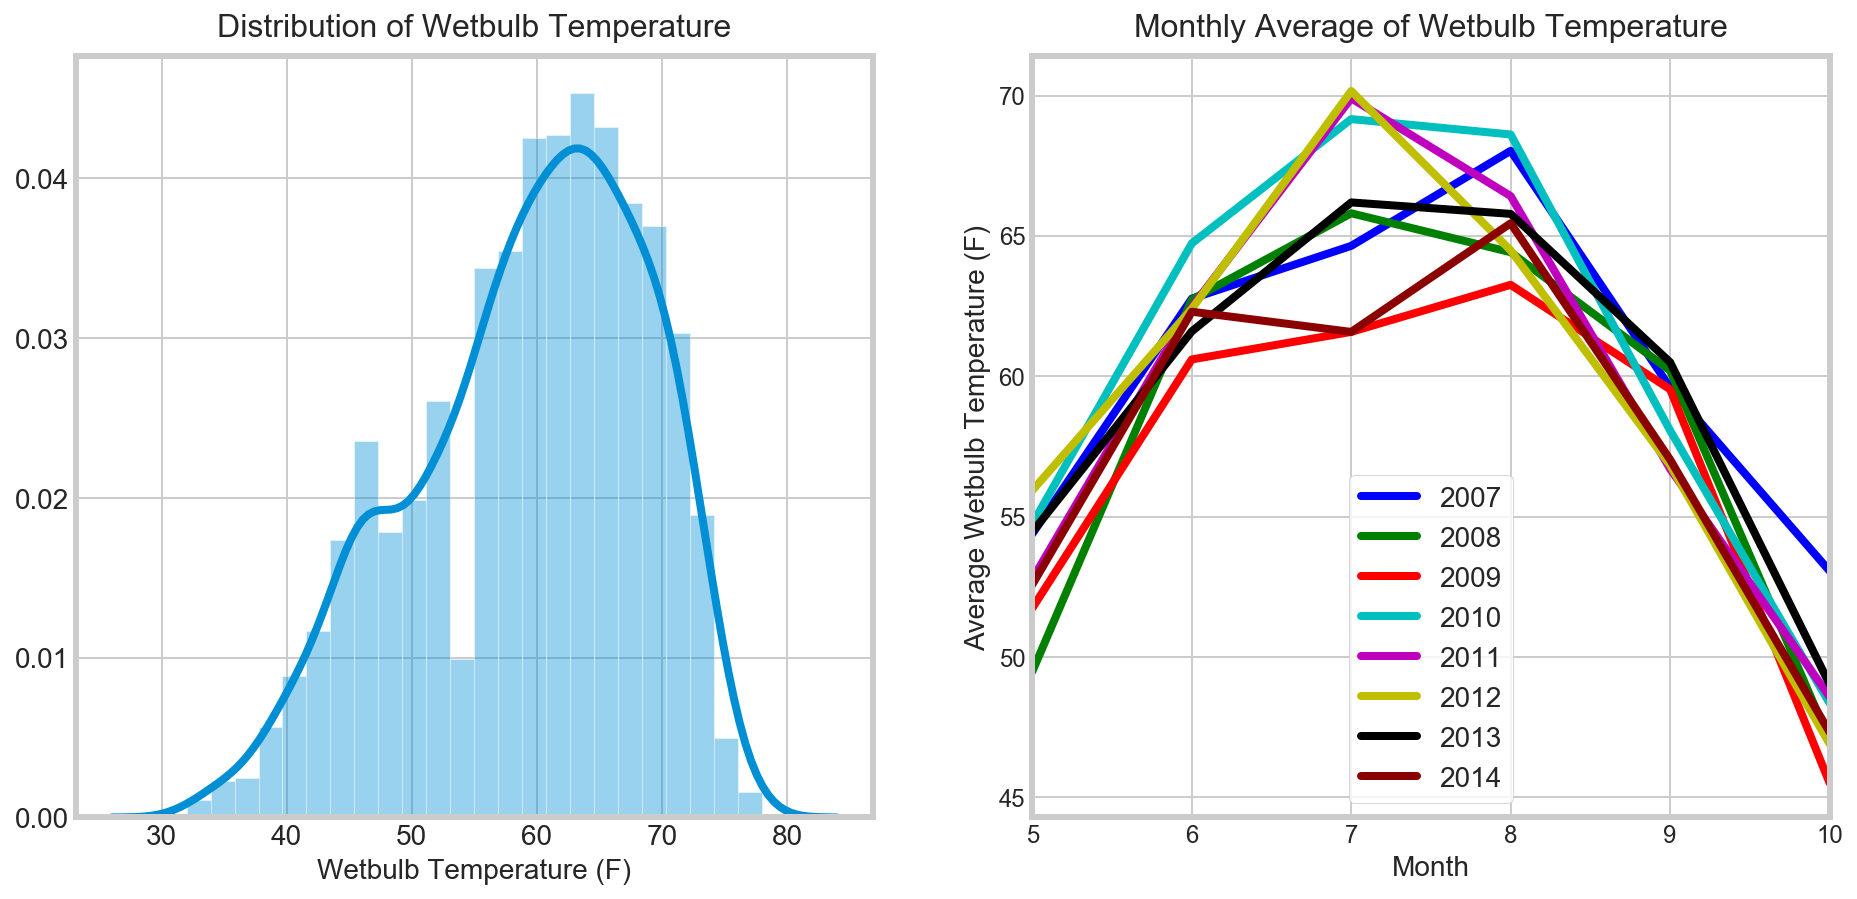

In [16]:
# Distribution of wetbulb temperature does not follow a normal distribution
# Wetbulb temperature peaks in Jul or Aug each year
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,7))
ax = ax.ravel()

sns.distplot(df_weather.wetbulb, ax=ax[0])
df_weather[df_weather['station']==1].groupby(['month','year']).wetbulb.mean().unstack(fill_value=0).plot(
    ax=ax[1], color=['b', 'g', 'r', 'c', 'm', 'y', 'k', 'darkred'])

ax[0].set_title('Distribution of Wetbulb Temperature', fontsize=16, y=1.01)
ax[0].set_xlabel('Wetbulb Temperature (F)', fontsize=14)
ax[0].tick_params(labelsize=14)

ax[1].set_title('Monthly Average of Wetbulb Temperature', fontsize=16, y=1.01)
ax[1].set_xlabel('Month', fontsize=14)
ax[1].set_ylabel('Average Wetbulb Temperature (F)', fontsize=14)
ax[1].tick_params(labelsize=12)
ax[1].legend(fontsize=14)

plt.subplots_adjust(wspace=0.2)

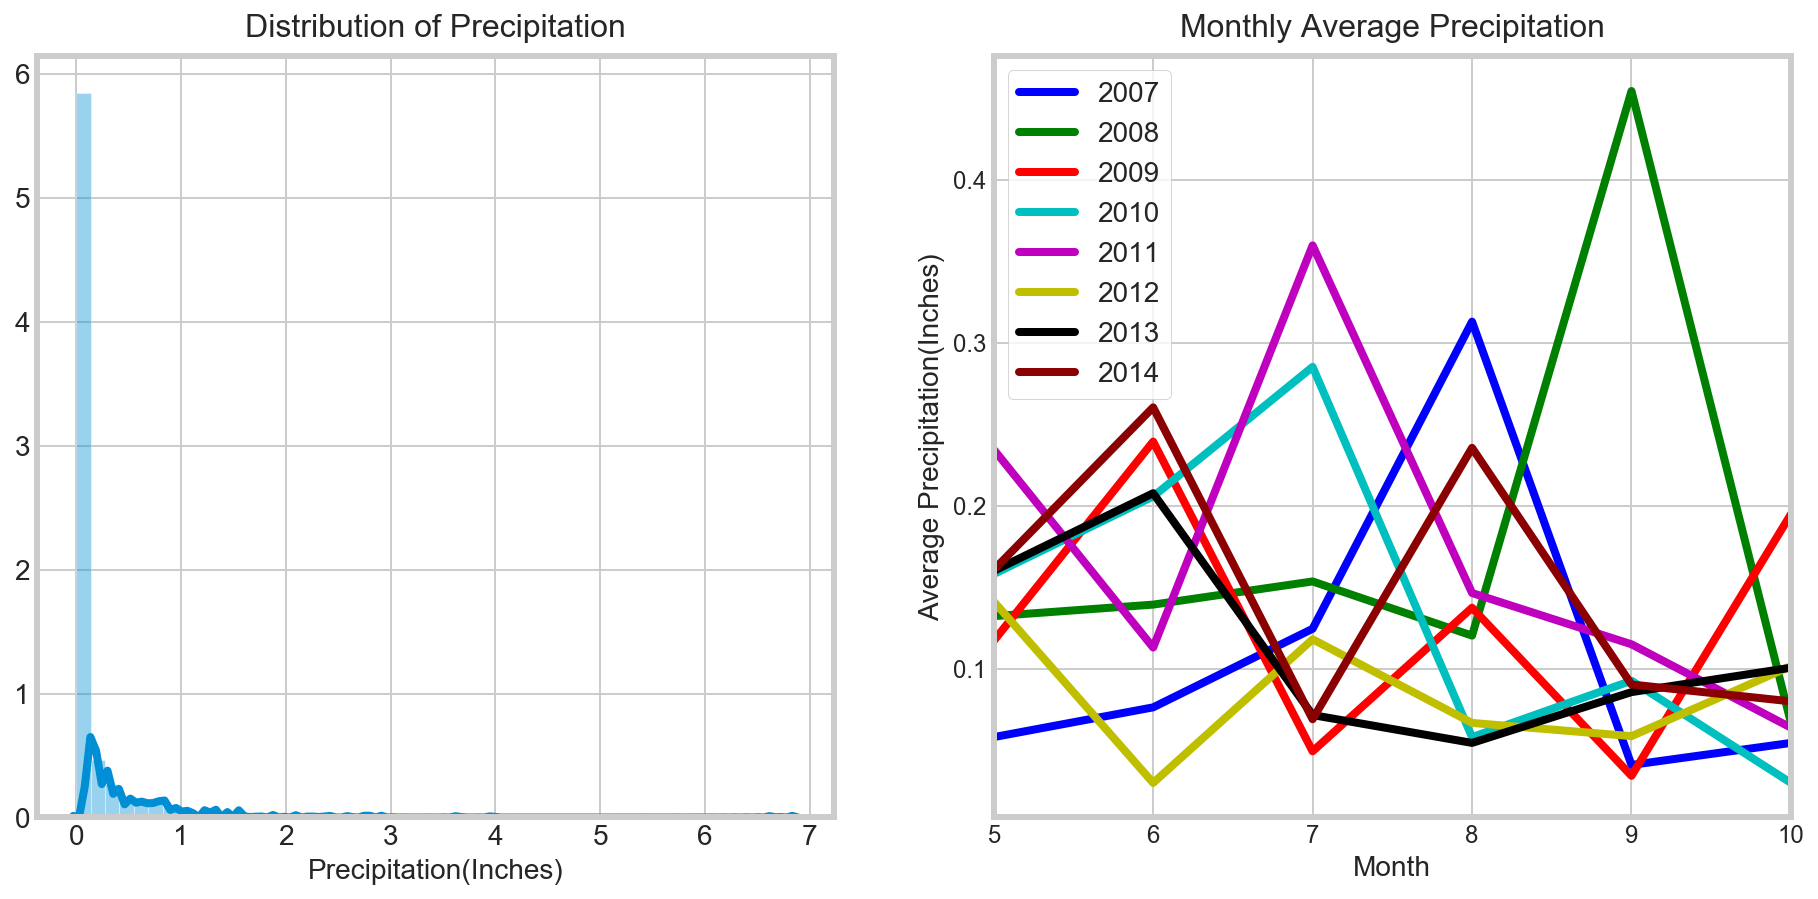

In [17]:
# Distribution of precipitation does not follow a normal distribution
# Monthly average precipitation does not show any trend throughout the years
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,7))
ax = ax.ravel()

sns.distplot(df_weather.preciptotal, ax=ax[0])
df_weather[df_weather['station']==1].groupby(['month','year']).preciptotal.mean().unstack(fill_value=0).plot(
    ax=ax[1], color=['b', 'g', 'r', 'c', 'm', 'y', 'k', 'darkred'])

ax[0].set_title('Distribution of Precipitation', fontsize=16, y=1.01)
ax[0].set_xlabel('Precipitation(Inches)', fontsize=14)
ax[0].tick_params(labelsize=14)

ax[1].set_title('Monthly Average Precipitation', fontsize=16, y=1.01)
ax[1].set_xlabel('Month', fontsize=14)
ax[1].set_ylabel('Average Precipitation(Inches)', fontsize=14)
ax[1].tick_params(labelsize=12)
ax[1].legend(fontsize=14)

plt.subplots_adjust(wspace=0.2)

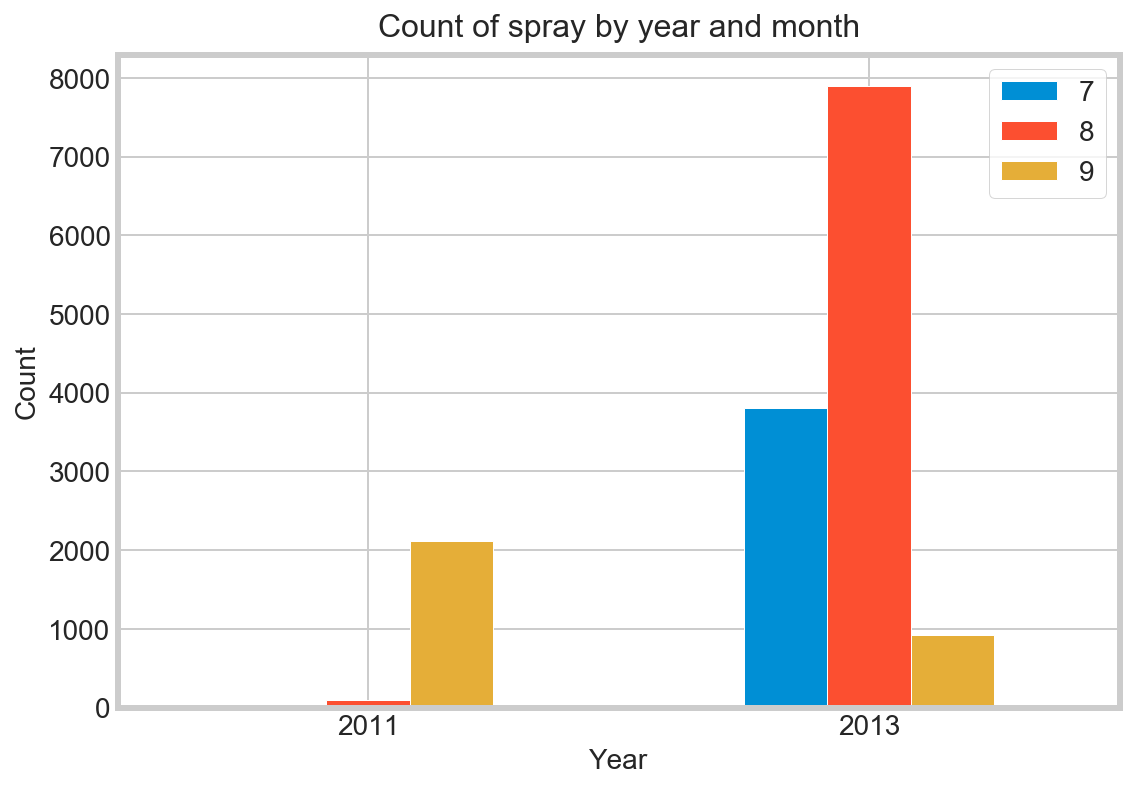

In [18]:
# Sprayed in Jul, Aug and Sep
df_spray.groupby(['year_spray', 'month_spray']).day_spray.count().unstack(fill_value=0).plot.bar(figsize=(8,6))
plt.xticks(rotation=0, fontsize=14)
plt.yticks(fontsize=14)
plt.title('Count of spray by year and month', fontsize=16, y=1.01)
plt.ylabel('Count', fontsize=14)
plt.xlabel('Year',fontsize=14)
plt.legend(fontsize=14)
plt.show()

### Visualisation on map

In [19]:
crs = {'init': 'epsg:4326'}

geometry_train = [Point(xy) for xy in zip(df_train['longitude'], df_train['latitude'])]

geo_df = gpd.GeoDataFrame(df_train,
                      crs=crs,
                      geometry=geometry_train)
geo_df.head()

,species,block,street,trap,nummosquitos,wnvpresent,year,month,day,latitude,longitude,geometry
0,CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,1,0,2007,5,29,41.954690,-87.800991,POINT (-87.800991 41.95469)
1,CULEX RESTUANS,41,N OAK PARK AVE,T002,1,0,2007,5,29,41.954690,-87.800991,POINT (-87.800991 41.95469)
2,CULEX RESTUANS,62,N MANDELL AVE,T007,1,0,2007,5,29,41.994991,-87.769279,POINT (-87.769279 41.994991)
3,CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,1,0,2007,5,29,41.974089,-87.824812,POINT (-87.82481199999999 41.974089)
4,CULEX RESTUANS,79,W FOSTER AVE,T015,4,0,2007,5,29,41.974089,-87.824812,POINT (-87.82481199999999 41.974089)


In [20]:
geometry_spray = [Point(xy) for xy in zip(df_spray['longitude'], df_spray['latitude'])]

geo_spray_df = gpd.GeoDataFrame(df_spray,
                      crs=crs,
                      geometry=geometry_spray)
geo_spray_df.head()

,latitude,longitude,year_spray,month_spray,day_spray,geometry
0,42.391623,-88.089163,2011,8,29,POINT (-88.0891633333333 42.3916233333333)
1,42.391348,-88.089163,2011,8,29,POINT (-88.0891633333333 42.3913483333333)
2,42.391022,-88.089157,2011,8,29,POINT (-88.0891566666667 42.3910216666667)
3,42.390637,-88.089158,2011,8,29,POINT (-88.0891583333333 42.3906366666667)
4,42.390410,-88.088858,2011,8,29,POINT (-88.08885833333331 42.39041)


In [21]:
#Station 1: CHICAGO O'HARE INTERNATIONAL AIRPORT Lat: 41.995 Lon: -87.933 Elev: 662 ft. above sea level
#Station 2: CHICAGO MIDWAY INTL ARPT Lat: 41.786 Lon: -87.752 Elev: 612 ft. above sea level

df_station = pd.DataFrame({
    'station': ["O'HARE INTERNATIONAL AIRPORT", "MIDWAY INTL ARPT"],
    'latitude': [41.995, 41.786],
    'longitude': [-87.933, -87.752]
})

geometry_station = [Point(xy) for xy in zip(df_station['longitude'], df_station['latitude'])]

geo_station_df = gpd.GeoDataFrame(df_station,
                      crs=crs,
                      geometry=geometry_station)
geo_station_df.head()

,station,latitude,longitude,geometry
0,O'HARE INTERNATIONAL AIRPORT,41.995,-87.933,POINT (-87.93300000000001 41.995)
1,MIDWAY INTL ARPT,41.786,-87.752,POINT (-87.752 41.786)


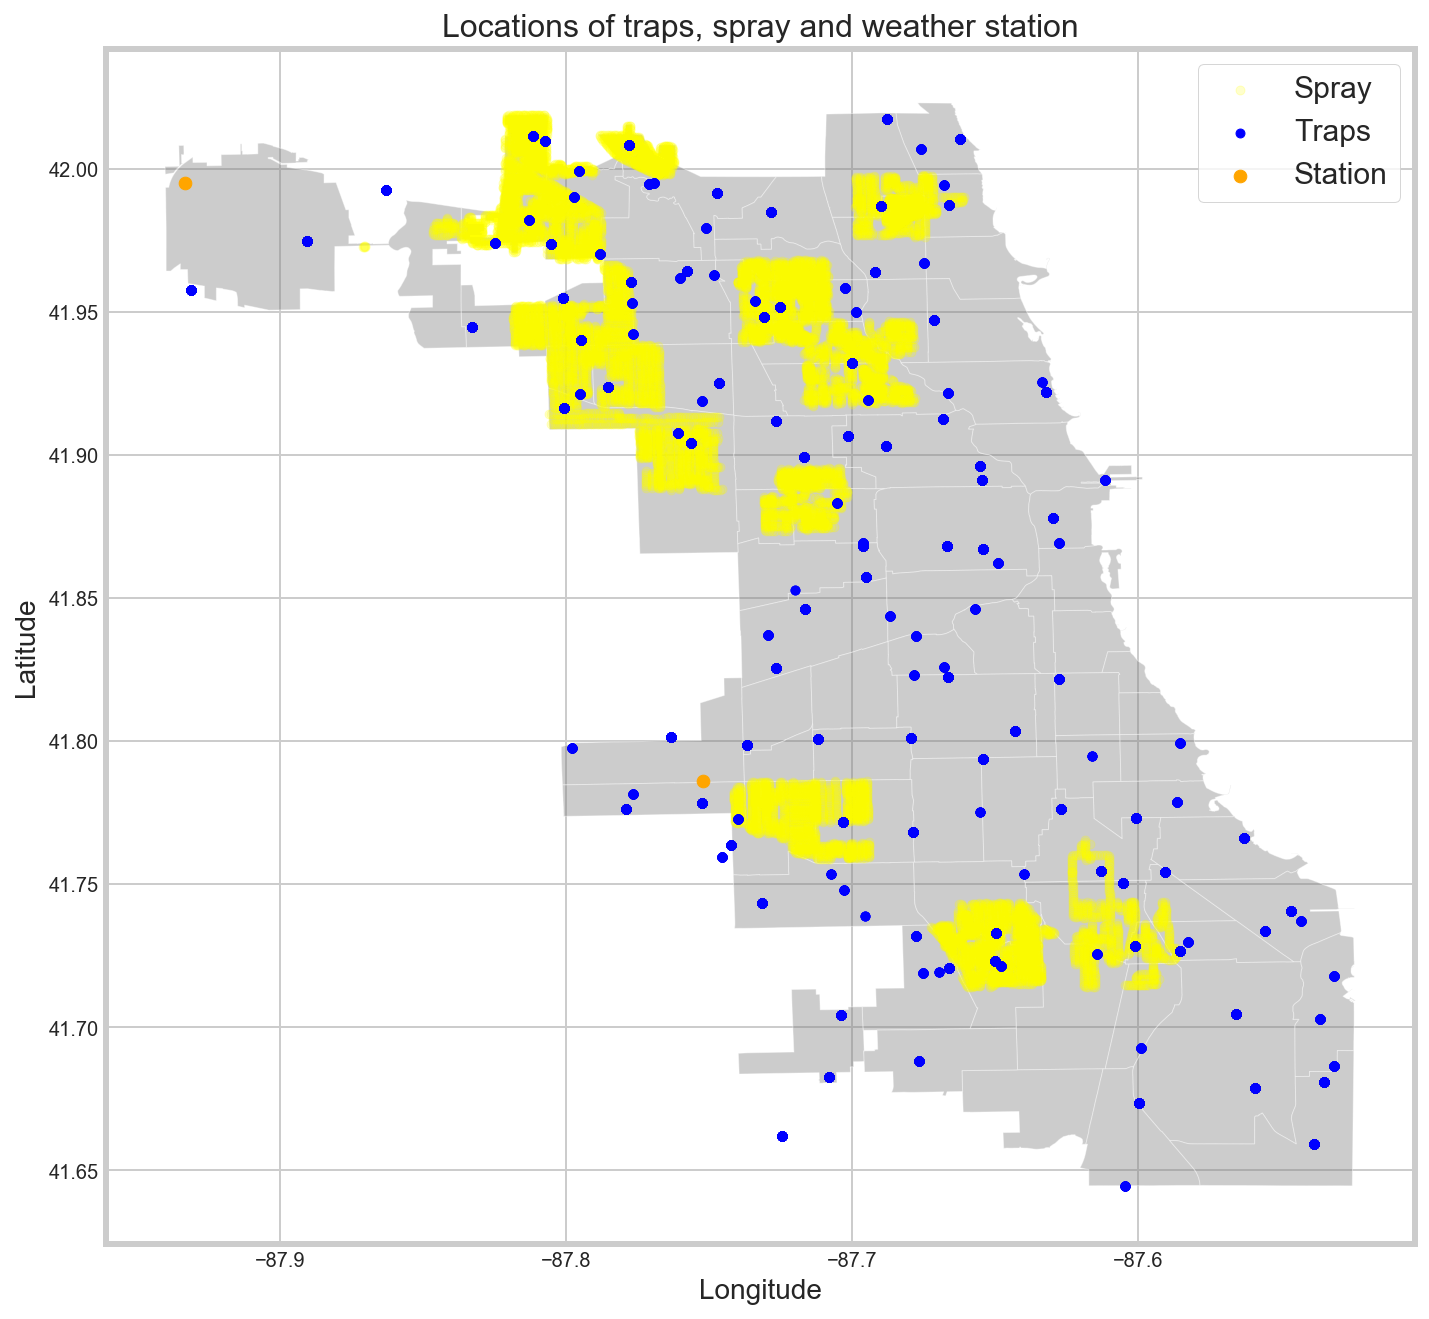

In [22]:
# Plot location of traps, spray and weather station
fig, ax = plt.subplots(figsize=(11,11))
street_map.plot(ax=ax, alpha=0.4, color='grey')
geo_spray_df[geo_spray_df['latitude']<42.3].plot(
    ax=ax, markersize=20, color='yellow', marker='o', alpha=0.2, label='Spray')
geo_df.plot(ax=ax, markersize=20, color='blue', marker='o', label='Traps')
geo_station_df.plot(ax=ax, markersize=40, color='orange', marker='o', label='Station')
plt.legend(prop={'size': 15})
plt.title('Locations of traps, spray and weather station', fontsize=16, y=1.01)
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.show()

C:\Users\JTEO0_000\Anaconda3\lib\site-packages\geopandas\plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


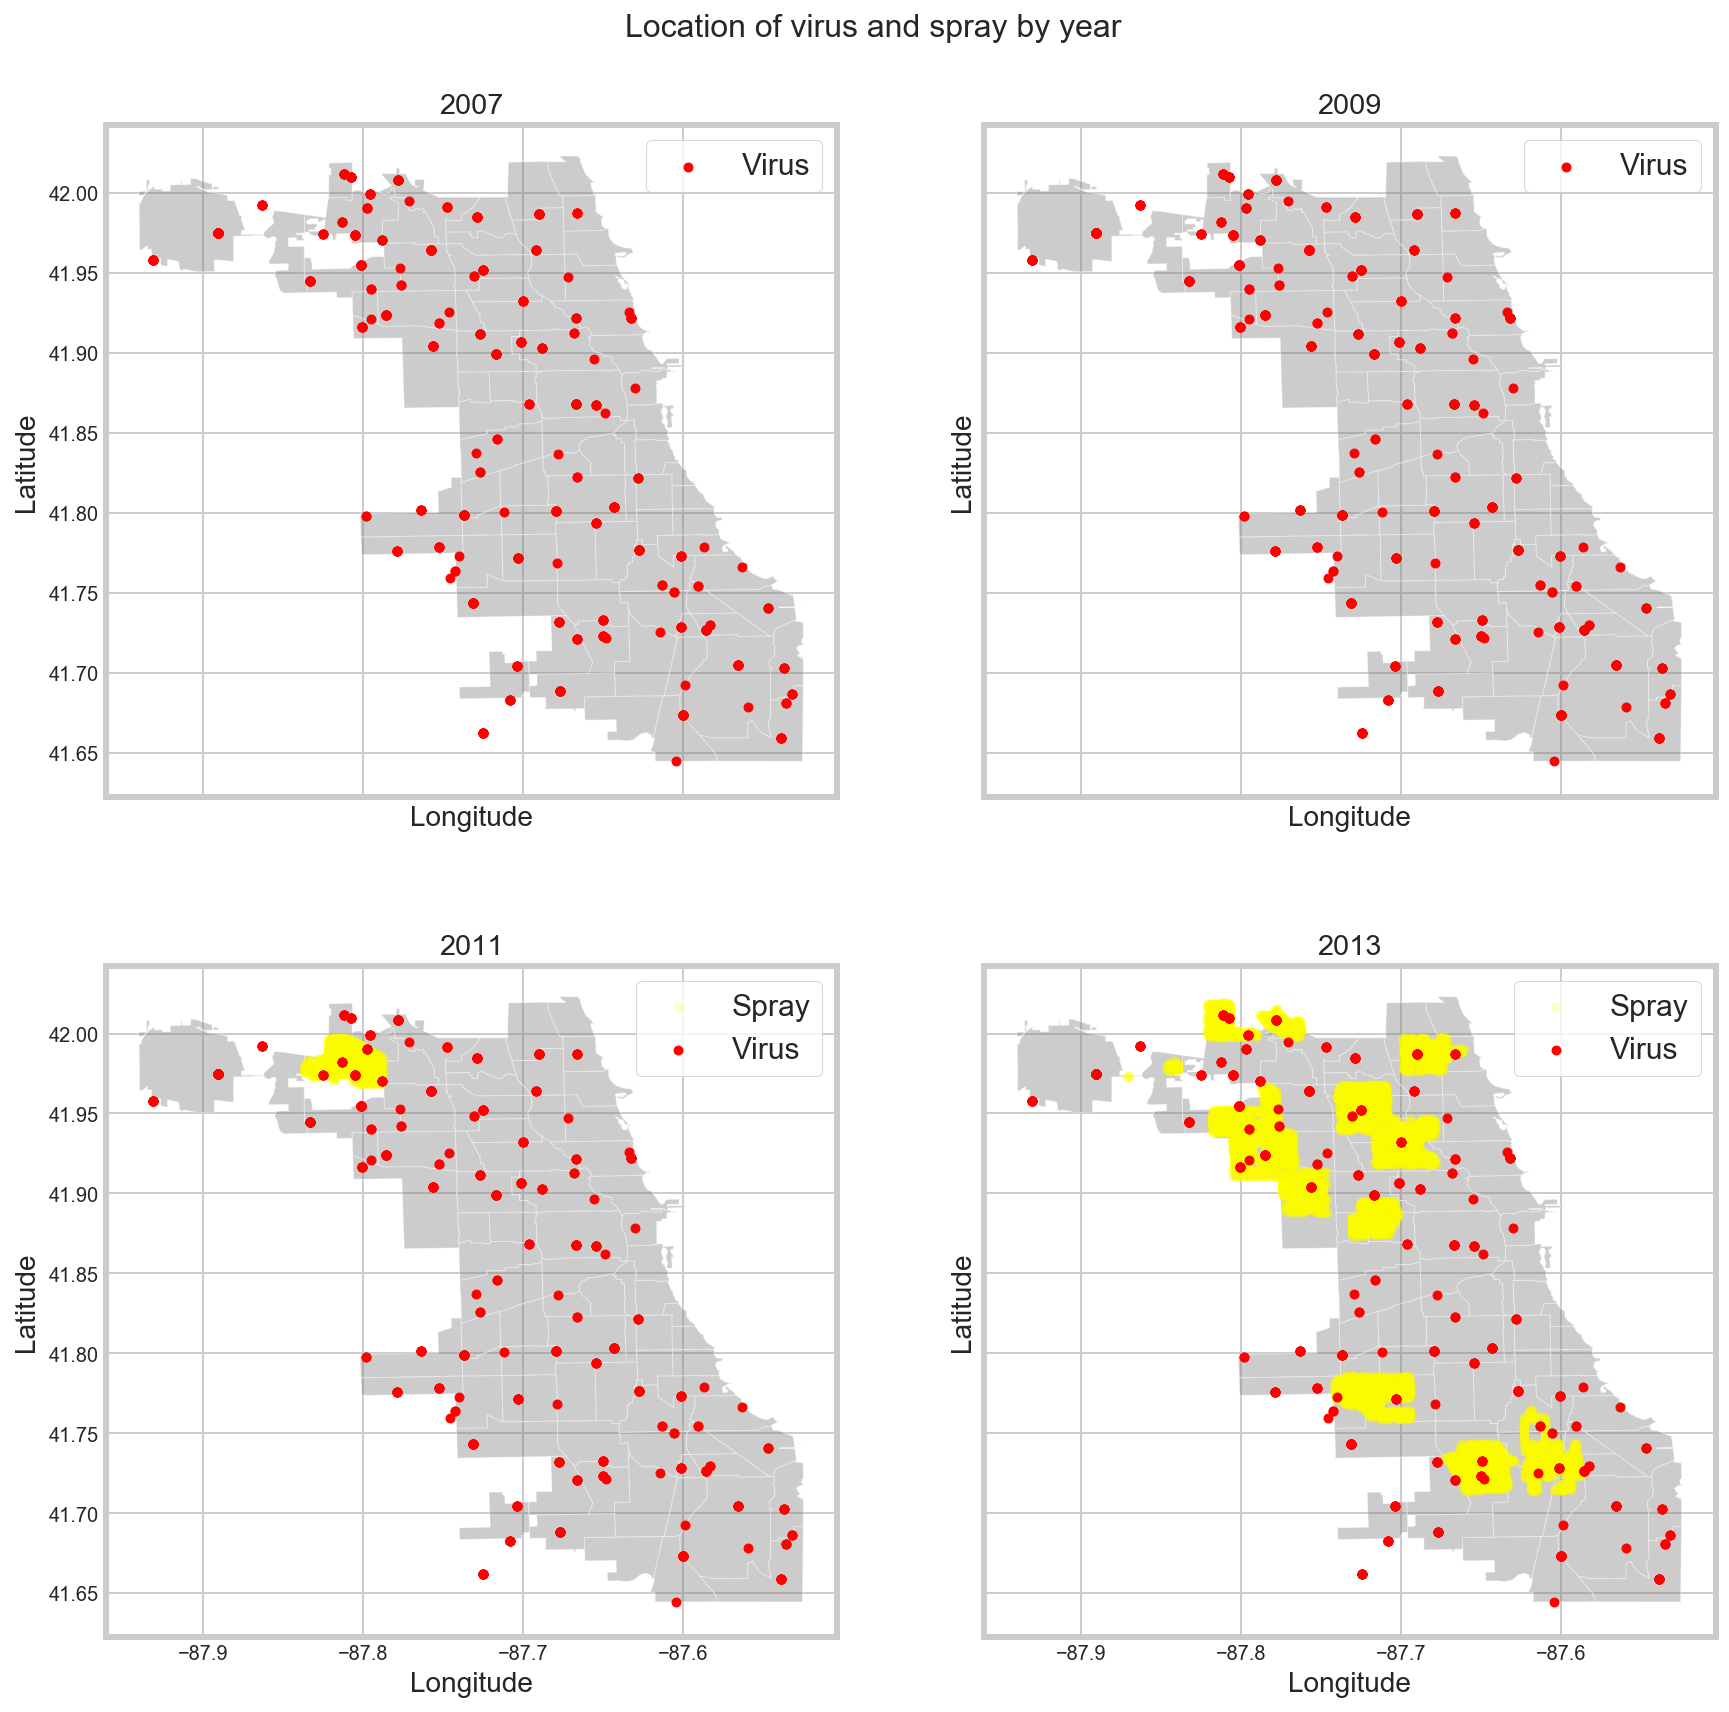

In [23]:
# Presence of virus still observed at locations sprayed - spray was not effective/ time sprayed was not correct?
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,12), sharex=True, sharey=True)
ax = ax.ravel()
plt.suptitle('Location of virus and spray by year', fontsize=16, y=1.01)
for i, y in enumerate(df_train.year.unique()):
    street_map.plot(ax=ax[i], alpha=0.4, color='grey')
    geo_spray_df[(geo_spray_df['latitude']<42.3) & (geo_spray_df['year_spray']==y)].plot(
        ax=ax[i], markersize=20, color='yellow', marker='o', alpha=0.2, label='Spray')
    geo_df[geo_df['wnvpresent']==1].plot(ax=ax[i], markersize=20, color='red', marker='o', label='Virus')
    ax[i].legend(prop={'size': 15})
    ax[i].set_title(y)
    ax[i].set_xlabel('Longitude', fontsize=14)
    ax[i].set_ylabel('Latitude', fontsize=14)
plt.tight_layout()
plt.subplots_adjust(wspace=0.2)